Consider the data in social_marketing.csv. This was data collected in the course of a market-research study using followers of the Twitter account of a large consumer brand that shall remain nameless---let's call it "NutrientH20" just to have a label. The goal here was for NutrientH20 to understand its social-media audience a little bit better, so that it could hone its messaging a little more sharply.

A bit of background on the data collection: the advertising firm who runs NutrientH20's online-advertising campaigns took a sample of the brand's Twitter followers. They collected every Twitter post ("tweet") by each of those followers over a seven-day period in June 2014. Every post was examined by a human annotator contracted through Amazon's Mechanical Turk service. Each tweet was categorized based on its content using a pre-specified scheme of 36 different categories, each representing a broad area of interest (e.g. politics, sports, family, etc.) Annotators were allowed to classify a post as belonging to more than one category. For example, a hypothetical post such as "I'm really excited to see grandpa go wreck shop in his geriatic soccer league this Sunday!" might be categorized as both "family" and "sports." You get the picture.

Each row of social_marketing.csv represents one user, labeled by a random (anonymous, unique) 9-digit alphanumeric code. Each column represents an interest, which are labeled along the top of the data file. The entries are the number of posts by a given user that fell into the given category. Two interests of note here are "spam" (i.e. unsolicited advertising) and "adult" (posts that are pornographic, salacious, or explicitly sexual). There are a lot of spam and pornography "bots" on Twitter; while these have been filtered out of the data set to some extent, there will certainly be some that slip through. There's also an "uncategorized" label. Annotators were told to use this sparingly, but it's there to capture posts that don't fit at all into any of the listed interest categories. (A lot of annotators may used the "chatter" category for this as well.) Keep in mind as you examine the data that you cannot expect perfect annotations of all posts. Some annotators might have simply been asleep at the wheel some, or even all, of the time! Thus there is some inevitable error and noisiness in the annotation process.

Your task to is analyze this data as you see fit, and to prepare a concise report for NutrientH20 that identifies any interesting market segments that appear to stand out in their social-media audience. You have complete freedom in deciding how to pre-process the data and how to define "market segment." (Is it a group of correlated interests? A cluster? A latent factor? Etc.) Just use the data to come up with some interesting, well-supported insights about the audience, and be clear about what you did.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")

In [2]:
social = pd.read_csv('social_marketing.csv').drop(columns='Unnamed: 0', axis=1)

In [3]:
social.columns

Index(['chatter', 'current_events', 'travel', 'photo_sharing', 'uncategorized',
       'tv_film', 'sports_fandom', 'politics', 'food', 'family',
       'home_and_garden', 'music', 'news', 'online_gaming', 'shopping',
       'health_nutrition', 'college_uni', 'sports_playing', 'cooking', 'eco',
       'computers', 'business', 'outdoors', 'crafts', 'automotive', 'art',
       'religion', 'beauty', 'parenting', 'dating', 'school',
       'personal_fitness', 'fashion', 'small_business', 'spam', 'adult'],
      dtype='object')

In [4]:
social.head()

,chatter,current_events,travel,photo_sharing,uncategorized,tv_film,sports_fandom,politics,food,family,...,religion,beauty,parenting,dating,school,personal_fitness,fashion,small_business,spam,adult
0,2,0,2,2,2,1,1,0,4,1,...,1,0,1,1,0,11,0,0,0,0
1,3,3,2,1,1,1,4,1,2,2,...,0,0,0,1,4,0,0,0,0,0
2,6,3,4,3,1,5,0,2,1,1,...,0,1,0,1,0,0,1,0,0,0
3,1,5,2,2,0,1,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0
4,5,2,0,6,1,0,0,2,0,1,...,0,0,0,0,0,0,0,1,0,0


##### We know that the variables: chatter, spam, uncategorized, and adult are non useful tweets.

##### As a first step, we can drop users whose tweets have been tagged under these non useful categories. Let us now check how much data we are left with post this removal.


In [5]:
unwanted_cat = ["spam", "chatter", "adult", "uncategorized"]
suspicious_cat_flag = (social[unwanted_cat].sum(axis=1) > 0).astype(int)

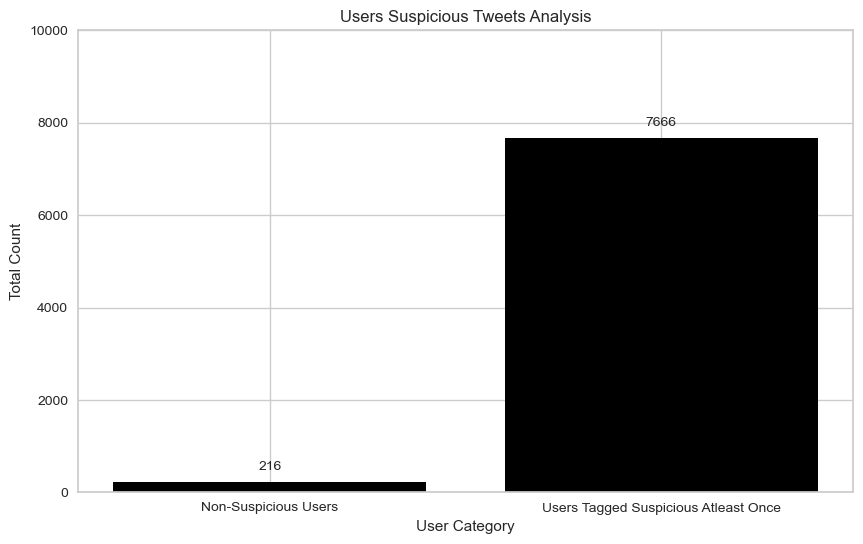

In [6]:
# Adding the 'suspicious_cat_flag' column to the DataFrame
social['suspicious_cat_flag'] = suspicious_cat_flag

# Grouping and summarizing the data
intdf = social.groupby('suspicious_cat_flag')['suspicious_cat_flag'].count().reset_index(name='total_records')

# Creating a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(intdf['suspicious_cat_flag'], intdf['total_records'], color='black')
plt.xlabel('User Category')
plt.ylabel('Total Count')
plt.title('Users Suspicious Tweets Analysis')
plt.xticks(intdf['suspicious_cat_flag'], ["Non-Suspicious Users", "Users Tagged Suspicious Atleast Once"])
plt.ylim(0, 10000)

# Adding labels to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 200, round(yval), ha='center', va='bottom', fontsize=10)

plt.show()

We introduce a 'suspicious_cat_flag' column, marking suspicious user categories. The data is summarized via grouping to quantify record counts for each flag value. Using Matplotlib, a bar plot is crafted, illustrating user categories on the x-axis and their respective record counts on the y-axis. This visualization provides a clear comparison of suspicious and non-suspicious user groups based on their tweet patterns

#### This account for majority of the users hence we cannot delete the user rows directly. Clearly, we cannot simply delete such a huge number of users (~97%)

##### Let's look at Suspicious(%) for each user i.e. (# of suspicious tweets/ Total # of tweets)

In [7]:
# Calculate the total number of posts for each user
social['total_posts'] = social.sum(axis=1)

In [8]:
social['suspicious_posts'] = social['suspicious_cat_flag'] * social['total_posts']

In [9]:
# List of unwanted categories
unwanted_cat = ["spam", "chatter", "adult", "uncategorized"]

# Calculate the total number of posts for each user
social['unwanted_posts'] = social[unwanted_cat].sum(axis=1)

# Calculate the total number of suspicious posts for each user
social['suspicious_posts'] = social['suspicious_cat_flag'] * social['unwanted_posts']

# Calculate the percentage of suspicious activity for each user
social['suspicious_percentage'] = (social['suspicious_posts'] / social['total_posts']) * 100

In [11]:
social['suspicious_percentage'].describe()

count    7882.000000
mean       14.710267
std         9.826756
min         0.000000
25%         7.142857
50%        12.765957
75%        20.408163
max        66.666667
Name: suspicious_percentage, dtype: float64

#### Considering everything below the 75%ile mark for suspicious %age rate
#### Meaning the users whose suspicious tweets is more than 20.4% of their total tweets will be filtered out from the dataset.


In [12]:
# Drop rows with suspicious percentage <= 15%
social = social[social['suspicious_percentage'] < 20.4]

In [13]:
# Drop the last 5 columns
social = social.iloc[:, :-5]

In [14]:
# Drop unwanted columns from the DataFrame
social = social.drop(columns=["chatter","uncategorized"])

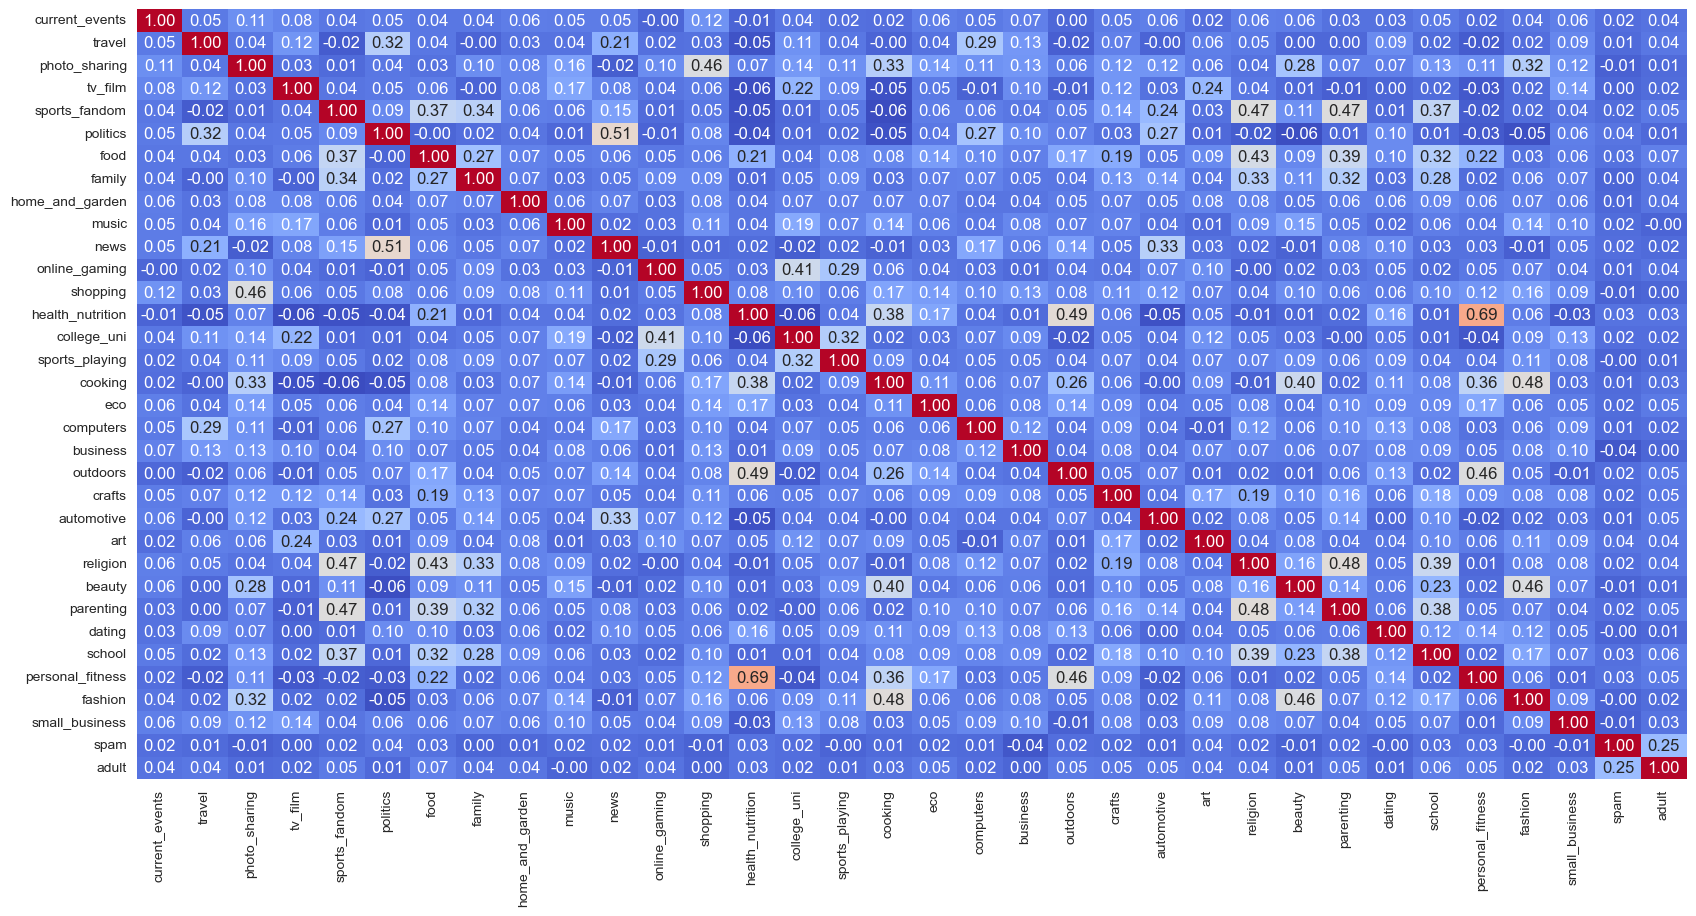

In [16]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.heatmap(social.corr(method='spearman'), annot=True, fmt='.2f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
plt.savefig('result.png', bbox_inches='tight', pad_inches=0.0)

Immediately on a cursory glance, we can see 6 clusters in the plot above:

• Fitness and Nature Enthusiasts: Eco, Outdoor, Health_Nutrition, Personal_Fitness

• Social Media Influencers: Beauty, Cooking, Fashion

• Family People : Family, School, Food, Sports Fandom, Religion, Parenting

• Geeky Traveller: Computer, Travel, Politics 

• Student: Sports Playing, Online Gaming, College University

• There is a ‘not so highly correlated cluster of’ art, crafts, and TV film as well

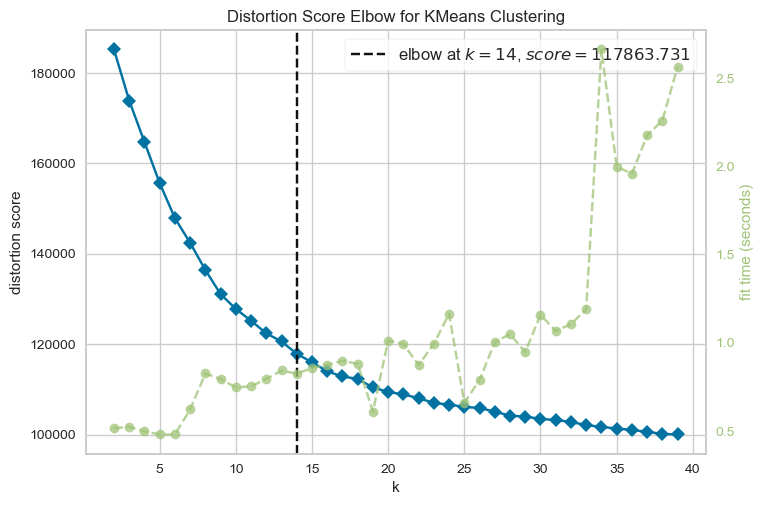

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(social)

# Use the Elbow method to find the optimal number of clusters
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 40))
visualizer.fit(scaled_data)
visualizer.show()

The data is standardized using the StandardScaler, which ensures that all features have a consistent scale. Then, the Elbow method is applied to determine the optimal number of clusters for KMeans clustering. This involves creating an instance of KMeans and utilizing the KElbowVisualizer to visualize the trend in within-cluster variance as the number of clusters increases. The "elbow point" on the resulting plot signifies the optimal cluster count, offering insights into the natural structure of the data

In [18]:
# Based on the elbow plot, determine the optimal number of clusters

# Perform k-means clustering with the optimal number of clusters
optimal_clusters = 13  # Update with the value you determined
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)

# Now, let's find the importance of columns for each cluster using k-means++
cluster_centers = kmeans.cluster_centers_

# Calculate the Euclidean distance between each point and cluster center
distances = np.linalg.norm(scaled_data[:, np.newaxis, :] - cluster_centers, axis=2)

# Assign each point to the nearest cluster
nearest_cluster = np.argmin(distances, axis=1)

# Determine the importance of columns for each cluster
cluster_importance = np.zeros((optimal_clusters, social.shape[1]))

for cluster in range(optimal_clusters):
    cluster_points = scaled_data[nearest_cluster == cluster]
    cluster_center = cluster_centers[cluster]
    cluster_importance[cluster] = np.mean(np.abs(cluster_points - cluster_center), axis=0)

The optimal cluster count is determined based on the elbow plot, and K-means clustering is executed with 13 clusters. Cluster labels are assigned to data points. For each cluster, the significance of columns is assessed by measuring the mean absolute difference between cluster points and their center using the k-means++ method. This step quantifies the column importance within clusters, revealing distinctive attributes of each group.

Cluster 1 - Top 3 columns:
personal_fitness
eco
outdoors


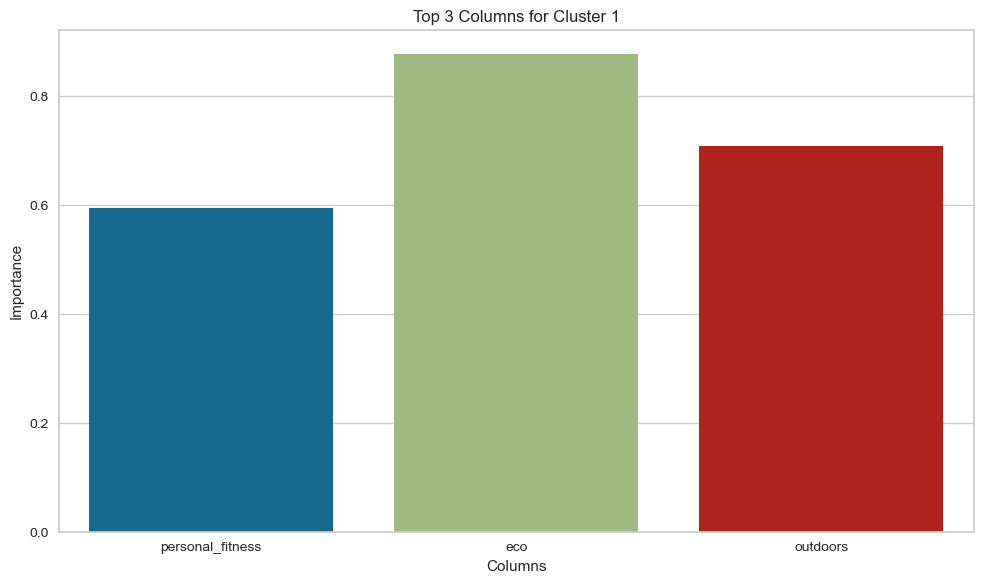

Cluster 2 - Top 3 columns:
small_business
travel
computers


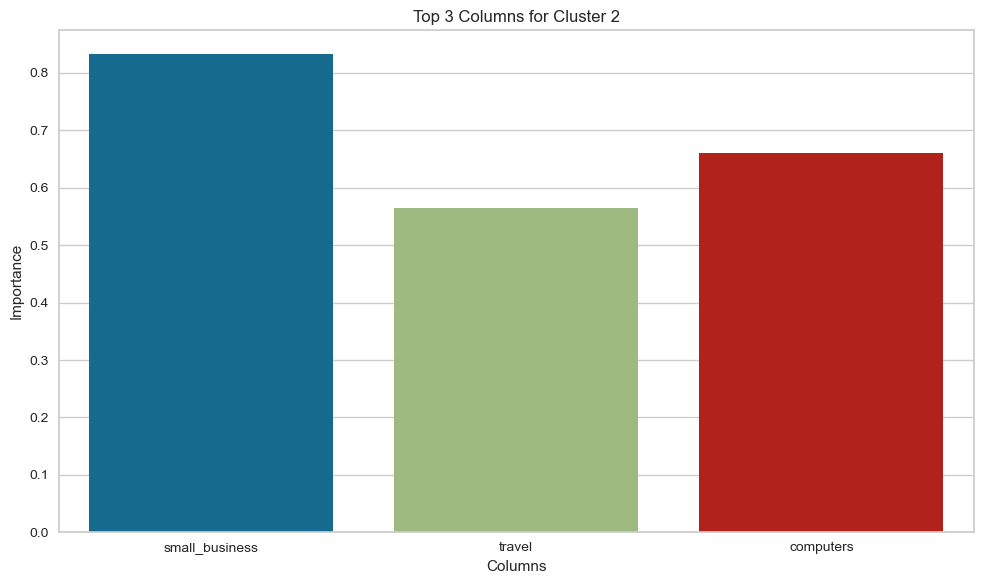

Cluster 3 - Top 3 columns:
tv_film
music
art


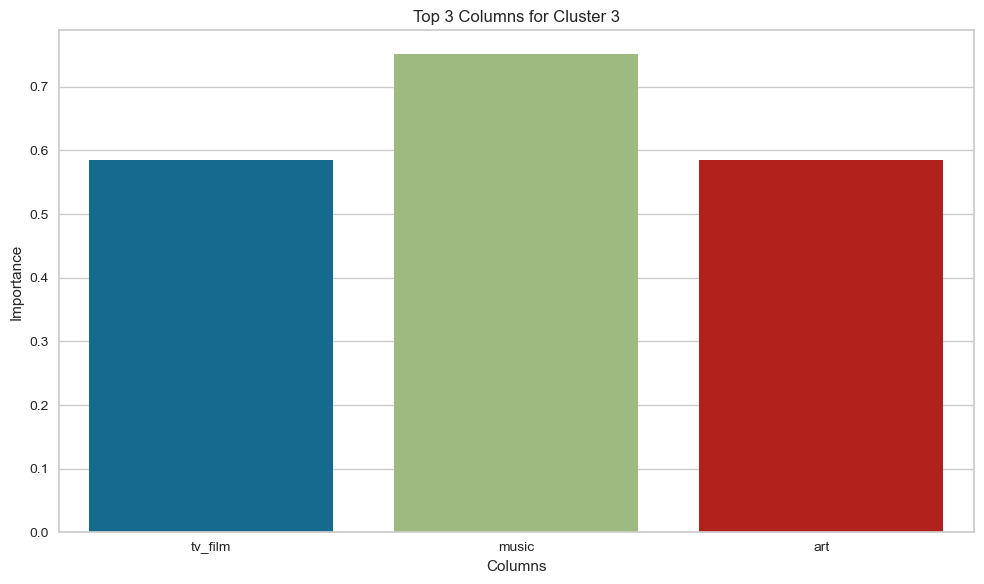

Cluster 4 - Top 3 columns:
school
crafts
family


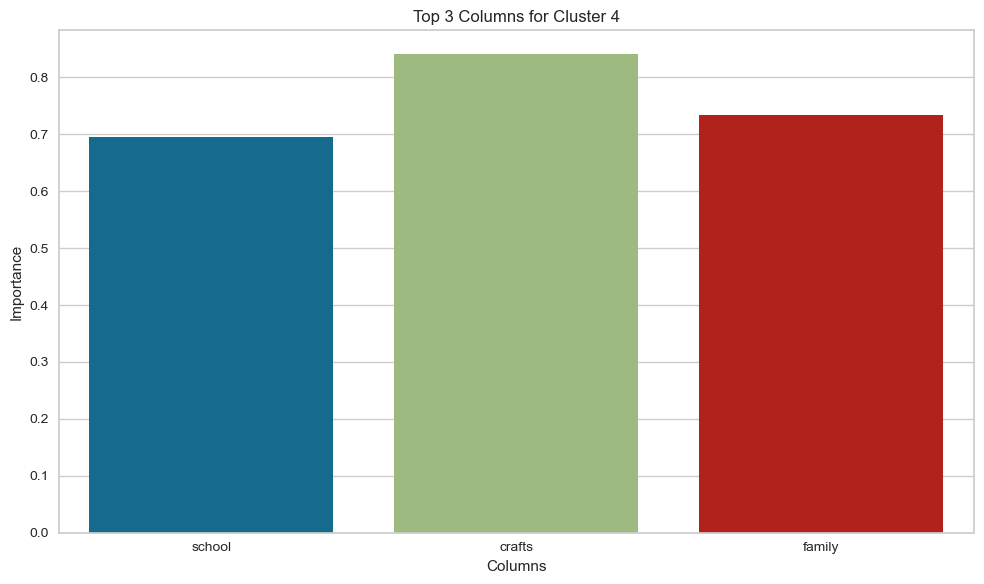

Cluster 5 - Top 3 columns:
eco
business
shopping


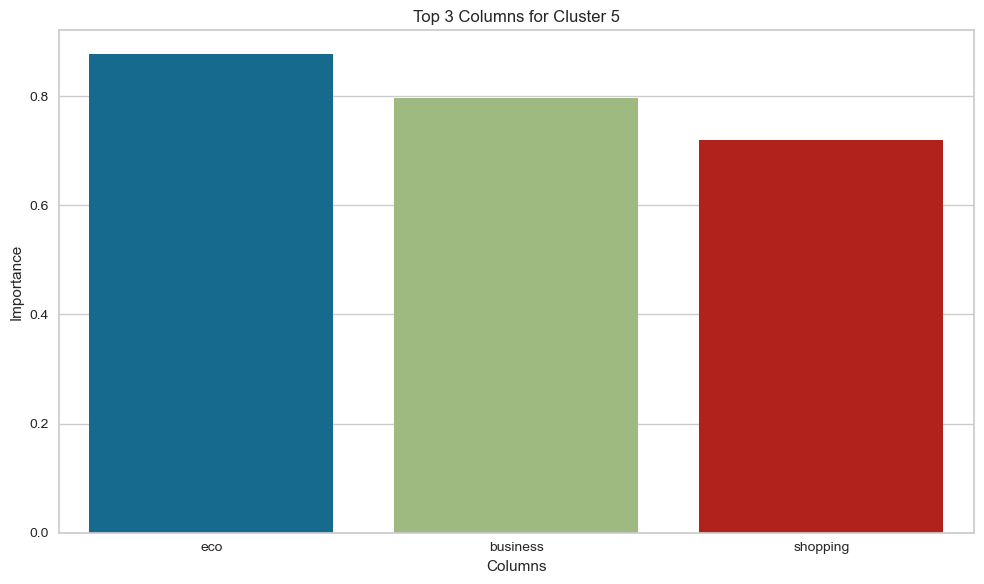

Cluster 6 - Top 3 columns:
cooking
fashion
beauty


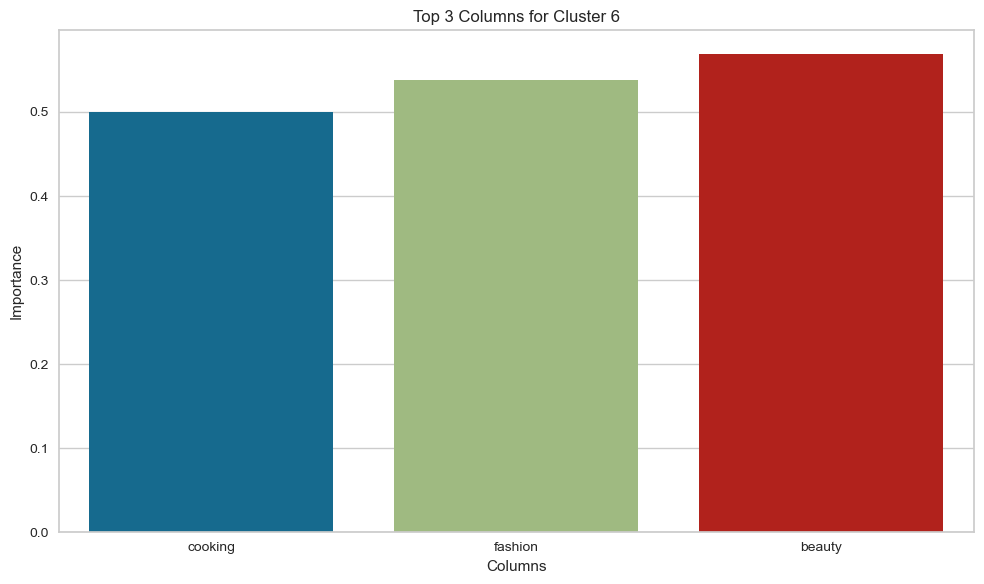

Cluster 7 - Top 3 columns:
home_and_garden
news
automotive


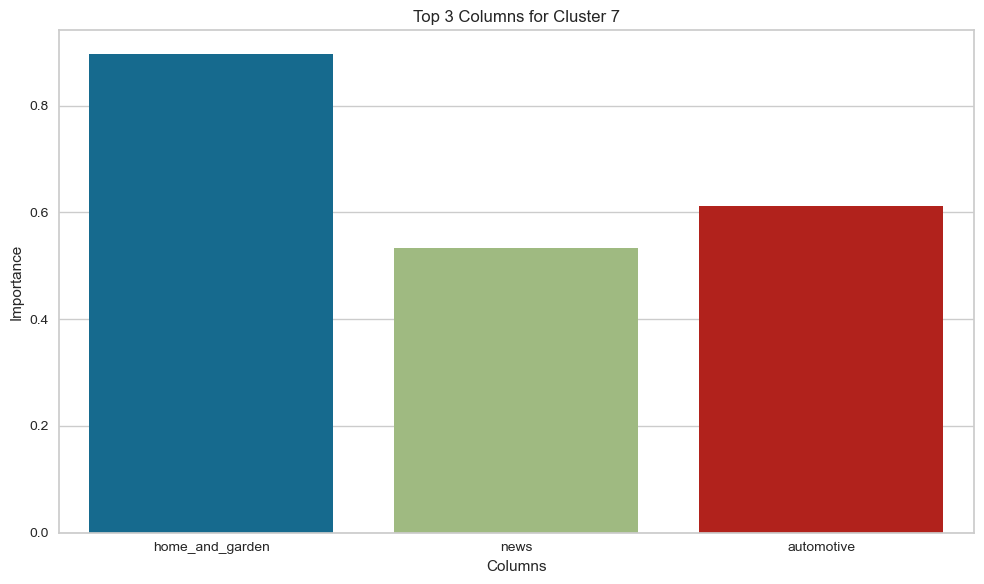

Cluster 8 - Top 3 columns:
computers
eco
adult


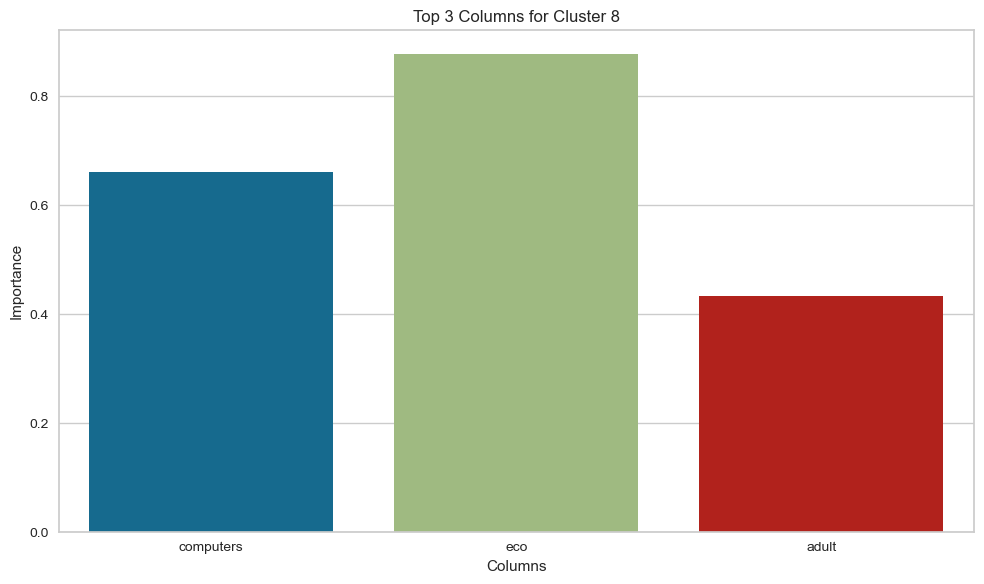

Cluster 9 - Top 3 columns:
home_and_garden
crafts
family


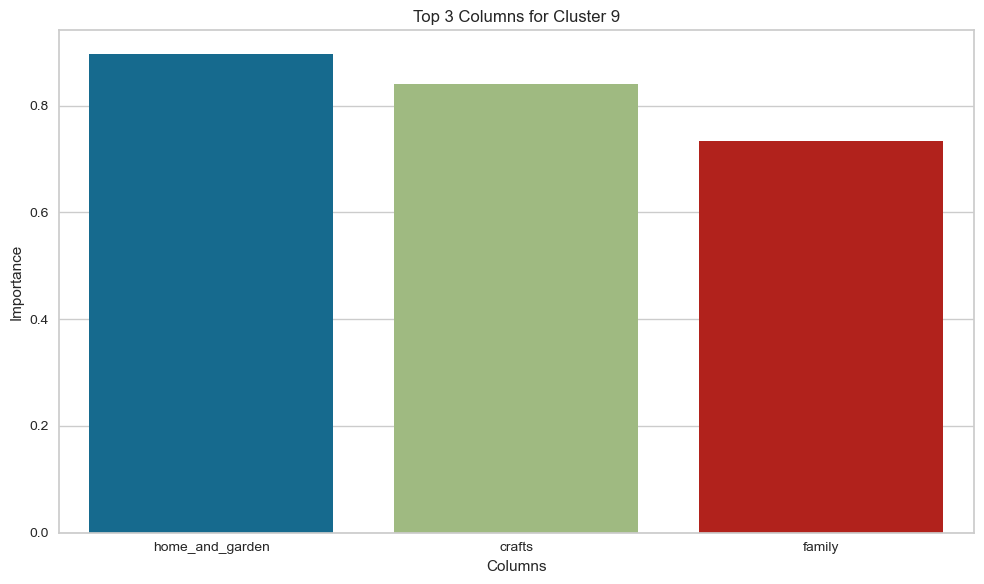

Cluster 10 - Top 3 columns:
business
school
dating


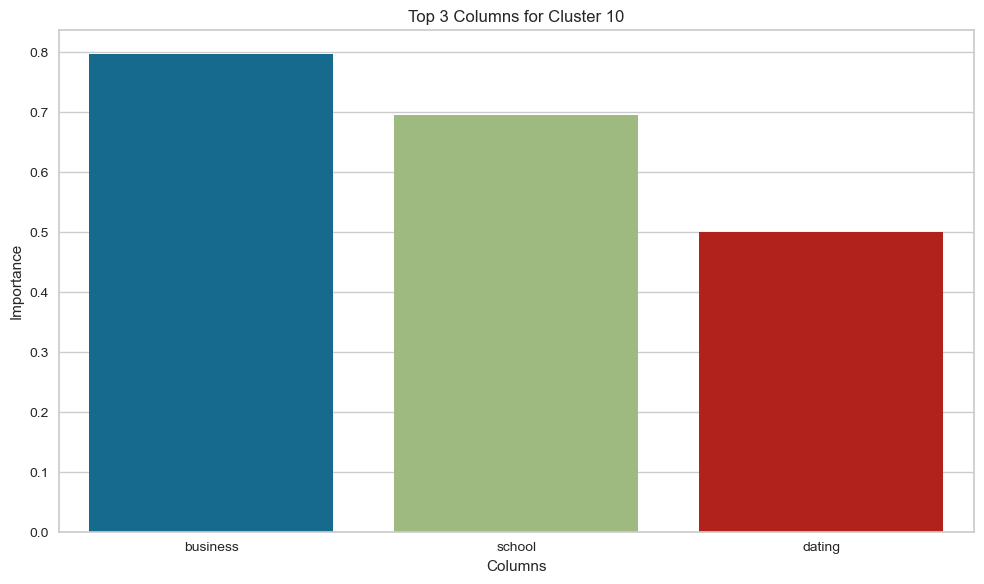

Cluster 11 - Top 3 columns:
music
home_and_garden
current_events


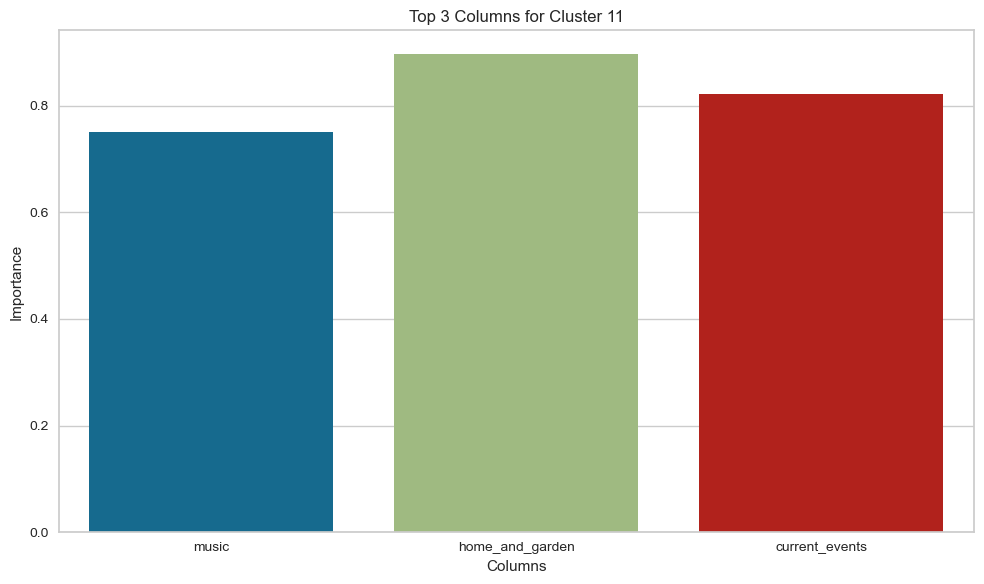

Cluster 12 - Top 3 columns:
college_uni
online_gaming
sports_playing


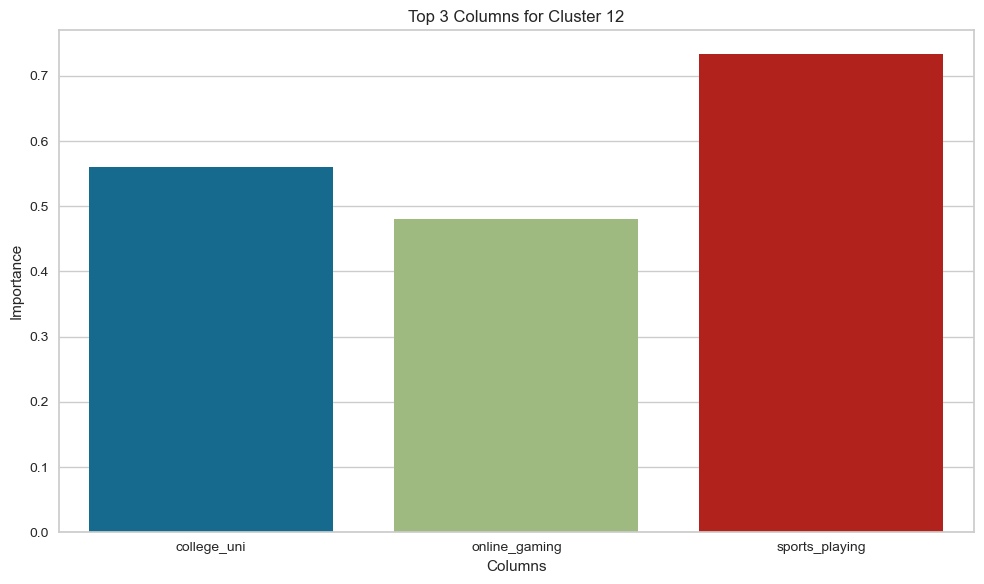

Cluster 13 - Top 3 columns:
home_and_garden
family
adult


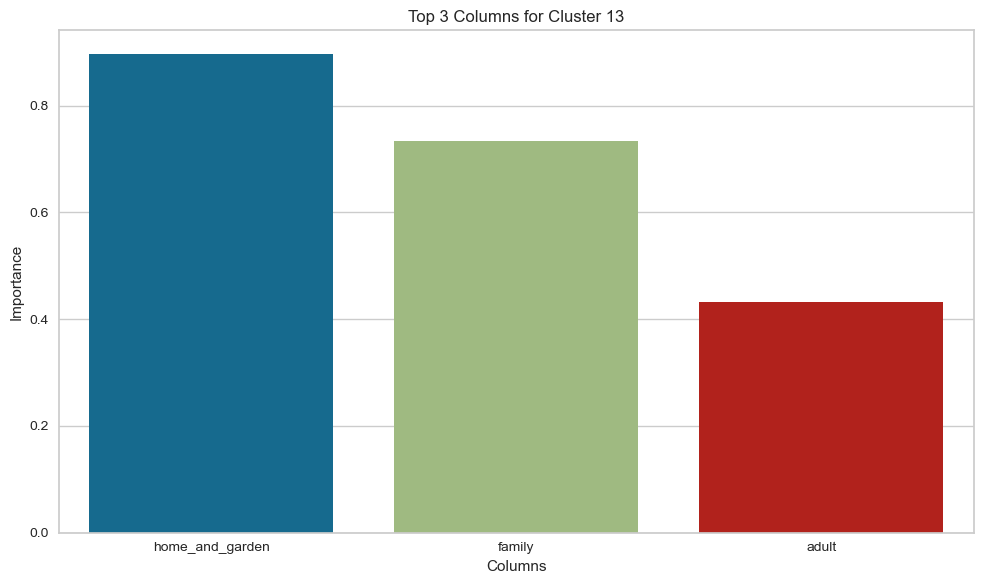

In [19]:
# Create a DataFrame to hold the importance values
importance_df = pd.DataFrame(cluster_importance, columns=social.columns)

# Find the top 3 columns for each cluster
top_cols_per_cluster = []
for cluster in range(optimal_clusters):
    top_cols = importance_df.columns[np.argsort(importance_df.iloc[cluster])[-3:]].tolist()
    top_cols_per_cluster.append(top_cols)

# Print the top 3 columns for each cluster
for cluster, top_cols in enumerate(top_cols_per_cluster):
    print(f"Cluster {cluster+1} - Top 3 columns:")
    for col in top_cols:
        print(col)
    
    # Create a bar plot for the top 3 columns of the current cluster
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df[top_cols], ci=None)  # Setting ci parameter to None
    plt.title(f'Top 3 Columns for Cluster {cluster+1}')
    plt.xlabel('Columns')
    plt.ylabel('Importance')    
    plt.tight_layout()
    plt.show()

Now let's try to improve on our results and see if we can find more division amongst the data points using dimensionality reduction techniques like PCA and t-SNE.

PCA

In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

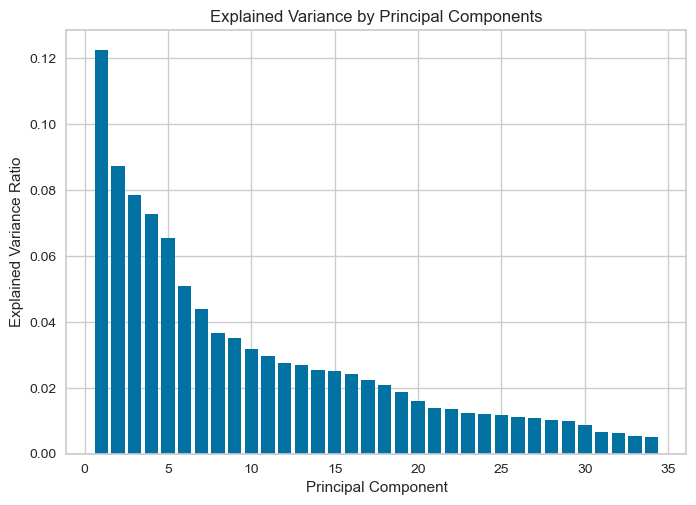

In [26]:
# Create a PCA object
pca_market = PCA()

# Fit and transform the data
PCA_M = pca_market.fit_transform(scaled_data)

# Get the explained variance ratio
explained_variance = pca_market.explained_variance_ratio_

# Plot the explained variance
plt.bar(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.show()

In [32]:
# Initialize PCA with the desired number of components
num_components = 2
pca2 = PCA(n_components=num_components)

# Perform PCA on the scaled data
pca_data = pca2.fit_transform(scaled_data)

t-SNE

In [28]:
from sklearn.manifold import TSNE

In [30]:
# Initialize t-SNE with desired perplexity (a hyperparameter)
perplexity = 30  # You can adjust this value
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)

# Fit and transform t-SNE on your data
tsne_results = tsne.fit_transform(social)

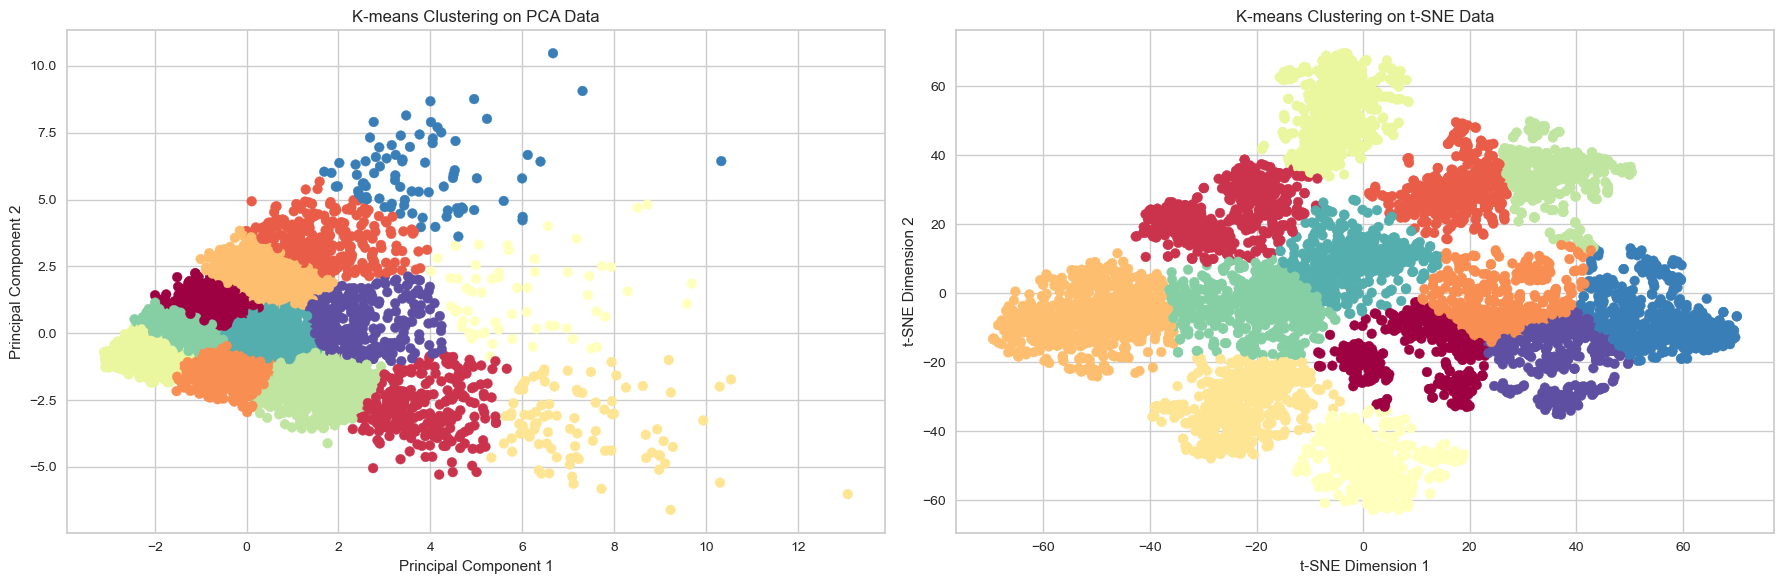

In [40]:
# Fit K-means clustering with 2 clusters on PCA data
pca_kmeans = KMeans(n_clusters = 13,init = 'k-means++', random_state=15)
pca_clusters = pca_kmeans.fit_predict(pca_data)

# Fit K-means clustering with 2 clusters on t-SNE data
tsne_kmeans = KMeans(n_clusters = 13,init = 'k-means++', random_state=15)
tsne_clusters = tsne_kmeans.fit_predict(tsne_df)

# Visualize the results
plt.figure(figsize=(18, 6))


plt.subplot(1, 2, 1)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=pca_clusters, cmap='Spectral')
plt.title("K-means Clustering on PCA Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.subplot(1, 2, 2)
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=tsne_clusters, cmap='Spectral')
plt.title("K-means Clustering on t-SNE Data")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

plt.tight_layout()
plt.show()

As we can see, there is not a lot to differentiate between clusters when we apply PCA and t-SNE as all the clusters are very close to each other. We will therefore go ahead with the segments we found using K-means clustering.

## Market Segmentation Report for NutrientH20 -

**Cluster 1 - Fitness and Nature Enthusiasts**:
   This cluster signifies individuals with interests in personal fitness, eco-friendly choices, and outdoor activities. Members might discuss health and wellness routines, sustainable living practices, and outdoor adventures.

**Cluster 2 - Geeky Traveller**:
   Members of this cluster may engage in discussions related to small business operations, travel experiences, and technology-related matters. This suggests a combination of business-oriented topics and technological interests.

**Cluster 3 - Creative and Artistic Pursuits**:
   This cluster is likely to involve discussions centered around television and film, music, and various forms of art. Members may share their creativity, artistic inspirations, and entertainment preferences.

**Cluster 4 - Education and Creativity Focus**:
   Members in this cluster could discuss school-related matters, engage in crafting activities, and share family-related conversations. The focus here appears to be on educational pursuits and creative expressions.

**Cluster 5 - Sustainable Business and Shopping Choices**:
   This cluster suggests discussions revolving around eco-friendly choices, business activities, and shopping decisions. Members might converse about sustainability, entrepreneurship, and consumer behaviors.

**Cluster 6 - Social Media Influencers**:
   The top variables indicate interests in cooking, fashion, and beauty. Conversations might involve sharing recipes, discussing fashion trends, and beauty tips.

**Cluster 7 - Home and Lifestyle Enthusiasts**:
   This cluster points to discussions about home improvement, staying updated with news, and exploring developments in the automotive industry.

**Cluster 8 - Technology, Environment, and Personal Interests**:
   The variables suggest discussions involving computers, eco-consciousness, and adult-oriented topics. This could indicate conversations about technology, environmental concerns, and personal matters.

**Cluster 9 - Home and Family Focus**:
   With interests in home improvement, crafting, and family-related discussions, this cluster likely engages in conversations related to enhancing living spaces and nurturing family relationships.

**Cluster 10 - Business, Education, and Social Engagements**:
    Discussions might involve school-related matters, dating interactions, and business activities. Members may share insights into academic pursuits, social relationships, and entrepreneurial ventures.

**Cluster 11 - Music, Home, and Current Events**:
    This cluster's interests suggest discussions about music, home improvement, and staying updated with current events. Members might share their musical preferences, engage in home-related conversations, and stay informed about ongoing developments.

**Cluster 12 - Student**:
    Members of this cluster could engage in discussions related to college and university matters, online gaming, and sports activities. This combination suggests conversations about education and recreational interests.

**Cluster 13 - Home, Family, and Personal Matters**:
    Conversations in this cluster could revolve around home improvement, family-related topics, and adult-oriented discussions. Members might share insights into enhancing their living spaces, family dynamics, and personal experiences.


As we can see, our earlier findings from the correlation matrix are backed up by the important columns of each cluster formed using KMeans. We also see some more clusters that we were not able to find which shows there are some non-linear relationships between the market segments. 

